# **Deep Generative Model for spectral image synthesis**
* 2180034 - Brayan Esneider Monroy Chaparro
* 2180045 - Geison Alfredo Blanco Rodriguez
* 2180018 - Iván David Ortiz Pineda

## Formulación matemática

Para la síntesis de imágenes utilizando como base imágenes RGB se planea la siguiente arquitectura sobre las redes entrenadas previamente:

<center><img src="https://i.ibb.co/TBDRc41/admm-1.png" width="60%"></center>

donde se hará uso de una imagen a escala de grises para establecer el problema de optimización. Específicamente, se buscará minimizar la diferencia entre la imagen a escala de grises ingresada $I$, y un promedio ponderado de todas las bandas de la imagen espectral para condicional que la representación $\alpha$ sea aprendida para ser similar a la imagen en escala de grises pero generando una imagen con espectro.

Para condicionar mejor el problema subyacente, se propone resolver para la síntesis el siguiente problema de optimización:

$$\hat{\alpha} = \underset{\alpha}{\text{argmin}} \left\{ \frac{1}{2}\| \Sigma_\lambda \hat{\mathbf f} - I \|_2^2 + \mu \mathcal R(G(\alpha)) \right\} \tag{1}$$

donde $\hat{\mathbf f} = G(\alpha)$ es la imagen hiperespectral generada sobre la base de representación, $\mu$ es un parámetro de regularización y $\mathcal R$ es un regularizador que condiciona la generación de $\alpha$ a cumplir ciertas propiedades previamente conocidas de la imagen.

Para el trabajo se escogió utilizar un regularizador TV, el cual busca que la diferencia entre firmas espectrales de pixeles adyacentes sea muy pequeña, lo que genera una imagen con transiciones suaves y bordes definidos.

Así, el problema de optimización estaría planteado como:
$$\hat{\alpha} = \underset{\alpha}{\text{argmin}} \left\{ \frac{1}{2}\| \Sigma_\lambda \hat{\mathbf f} - I \|_2^2 + \mu \mathcal \| \nabla_{xy} G(\alpha) \|_1 \right\} \tag{1}$$
donde $\nabla_{xy}$ es una matriz que calcula la diferencia entre vectores adyacentes.


Se plantea el uso de una sustitución de la forma $z = \nabla_{xy} G(\alpha)$ obteniendo así el problema:

\begin{array}{cc}
\min_{\alpha, z} & \left\{ \frac{1}{2}\| \Sigma_\lambda \hat{\mathbf f} - I \|_2^2 + \mu \|z\|_1 \right\} \\
\text{s.t.} & z = \nabla_{xy} G(\alpha)
\end{array}

El lagrangiano del problema estaría dado como:

$$\mathcal L(\alpha, z, u) = \frac{1}{2}\| \Sigma_\lambda \hat{\mathbf f} - I \|_2^2 + \mu \|z\|_1 + \frac{\rho}{2}\| \nabla_{xy}G(\alpha) - z + u \|_2^2$$

Así, siguiendo una metodología de ADMM, se tendría que los pasos de actualización de las variables estarían dados por:

$$
\alpha^{k+1} = \text{argmin}_{\alpha} \mathcal L\left(\alpha, z^k, u^k\right) \\
z^{k+1} = \text{argmin}_{z} \mathcal L\left(\alpha^{k+1}, z, u^k\right) \\
u^{k+1} = u^k + \nabla_{xy} G(\alpha^{k+1}) - z^{k+1}
$$


Para el paso de actualización de $\alpha$, se tendría que esta podría ser resuelta mediante un algoritmo de optimización sobre una red neuronal que relacione las 2 funciones de pérdida (normas $\ell_2$) dependientes de $\alpha$. Para esto se haría uso de un optimizador ADAM:
$$ \alpha^{k+1} = \textbf{ADAM}(\alpha^k) $$

Para el paso de actualización de $z$, se hará uso de un projector sobre norma $\ell_1$ conocido como el operador *soft-thresholding* definiendo el paso de actualización como:
$$ z^{k+1} = \mathcal S_{\mu/\rho} (\nabla_{xy} G(\alpha^{k+1}) + u^k) $$


## Implementación del algoritmo

In [ ]:
#@title **Código:** conexión con el drive

from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/My Drive/ProyectoIA2/generative-spectral-datasets')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title **Código:** importando librerías

import tensorflow as tf
import numpy as np
from models.main import make_encoder, make_generator, make_discriminator, spectralGAN, spectralGen
from models.utils import discriminator_loss, autoencoder_loss, generator_loss, spacial_tv, soft_threshold
from models.metrics import PSNR, SSIM
from data import load_dataset

import matplotlib.pyplot as plt

input_shape = (512,512,31)

In [ ]:
#@title **Código:** cargando el dataset

BATCH_SIZE = 1

train_params = dict(
    batch_size = BATCH_SIZE,
    shuffle = True,
    cache = True
)

test_params = dict(
    batch_size = BATCH_SIZE,
    cache = True
)

_ , test_ds = load_dataset( train_params = train_params, test_params = test_params)

In [ ]:
#@title **Código:** definiendo el optimizador y arquitectura de la red

FACTOR = [ 1 , 1 , 1/2 , 1/2 , 1/4, 1/8]
features= 64

encoder = make_encoder(input_shape, features=features, factors=FACTOR)
generator = make_generator(input_shape, features=features, factors=FACTOR)
discriminator = make_discriminator(input_shape)

In [ ]:
#@title **Código:** mostrando la arquitectura de las redes

encoder.summary()
generator.summary()
discriminator.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 31)]    0         
_________________________________________________________________
encoder (Encoder)            (None, 512, 512, 8)       59184     
Total params: 59,184
Trainable params: 59,184
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 8)]     0         
_________________________________________________________________
generator (Generator)        (None, 512, 512, 31)      59230     
Total params: 59,230
Trainable params: 59,230
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________

In [ ]:
#@title **Código:** definiendo la arquitectura

from tensorflow.keras.callbacks import ModelCheckpoint

model = spectralGAN(encoder=encoder, generator=generator, discriminator=discriminator)

model.compile(
    a_optimizer = tf.keras.optimizers.Adam(1e-4),
    d_optimizer = tf.keras.optimizers.Adam(1e-4),
    a_loss = autoencoder_loss,
    d_loss = discriminator_loss,
    metrics = [ PSNR() ]
)


x0 = tf.constant(0. , shape=(1,) + input_shape)
model.__call__(x0)
model.load_weights('spectralGAN.h5')

In [ ]:
#@title **Código:** evaluando el modelo

metrics = model.evaluate(test_ds)

3/3 [==============================] - 2s 440ms/step - a_loss: -5.3580e-05 - d_loss: 1.3980 - psnr: 41.1308 - real_acc: 0.3763 - fake_acc: 0.5033


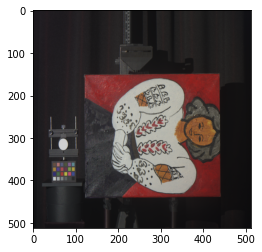

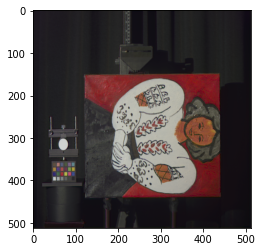

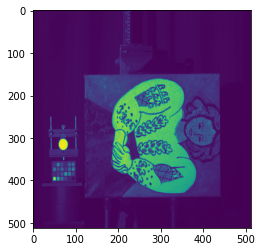

In [ ]:
#@title **Código:** mostrando imagen de testeo

sample = next(iter(test_ds))
target = tf.reduce_mean( sample, axis=-1, keepdims=True)

alpha = encoder.predict(sample)
generated = generator.predict(alpha)

num = 0
RGB = [ 24, 15 , 5]

x_true = np.power( sample, 0.5 )
x_pred = np.power( generated, 0.5 )

plt.imshow(x_true[num][:,:,RGB])
plt.show()

plt.imshow(x_pred[num][:,:,RGB])
plt.show()

plt.imshow(target[0, : ,:, 0])
plt.show()


In [ ]:
#@title **Código:** algoritmo de síntesis de imágenes

rho = 1
tau = 0.1*rho


optimizer = tf.keras.optimizers.Adam(5e-2)
model_gen = spectralGen(encoder=encoder, generator=generator, discriminator=discriminator, rho=rho)
model_gen.compile( optimizer=optimizer, loss=['binary_crossentropy'], metrics=['accuracy'])

alpha0 = tf.ones( (1,512,512,8) )
y_true = tf.ones( (1,127,127,1) )


u = tf.zeros( (1,512,512,31) )
y_pred = model_gen.predict([alpha0, target, u])

plt.imshow(y_pred[0,:,:,0] )
plt.show()
iters = 20

alpha = model_gen.alpha.alpha 
Da  = generator(alpha[None,:])
z = soft_threshold(  spacial_tv(Da) + u , tau, rho )

for i in range(iters):
  # alpha update
  model_gen.fit( x=[alpha0, target, u - z], y = y_true , epochs=100  )
  # -----
  alpha = model_gen.alpha.alpha 
  Da = generator(alpha[None,:])
  tv_Da = spacial_tv(Da)
  # z update
  z = soft_threshold( tv_Da + u )
  # u update
  u = u + tv_Da - z

  estimated = generator(alpha[None, :]).numpy()
  plt.imshow(estimated[0][:,:, RGB])
  plt.show()


  

Output hidden; open in https://colab.research.google.com to view.

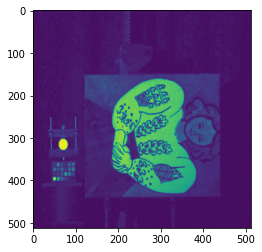

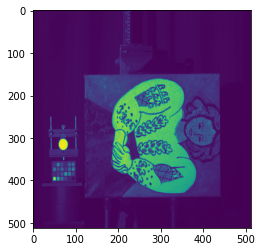

In [ ]:
#@title **Código:** comparando imagen real y target

x = tf.reduce_mean(estimated, axis=-1)
plt.imshow(x[0])
plt.show()

plt.imshow(target[0,:,:,0])
plt.show()

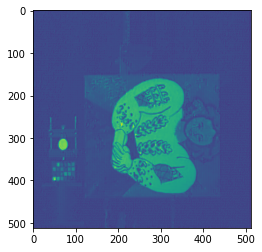

In [ ]:
#@title **Código:** mostrando alpha

plt.imshow(alpha[ : ,:, 0])